In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Generate data

In [6]:
def generateData():
    n = 50
    d = 75
    k = 5 
    sigma = 1

    # generate x_i
    cov_mat = np.identity(d)
    avg = np.zeros((d,))
    x = np.random.multivariate_normal(avg,cov_mat,n)

    # epsilon vec
    epsilon_vec = np.random.normal(loc=0,scale=sigma)

    # w_star_0
    w_star_0 = 0
    w_star = np.zeros((d,))
    w_star[0:k] = np.random.randint(low = 1,high=3, size=k)
    w_star[w_star==2] = -10
    w_star[w_star==1] = 10


    # generate y 
    y = np.dot(x,w_star) + w_star_0 + epsilon_vec
    
    return y,x,w_star,k
    
def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    for k_ind in np.arange(k):
        
        lambda_val = 2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y)))
        lambda_vec.append(lambda_val)
    lambda_max = np.max(lambda_vec)
    return lambda_max

    
### lasso!
def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])
            
            # bool version
            mask = np.ones(d,dtype=bool)
            mask[k] = 0
            x_temp = x[:,mask]
            w_temp = w[mask]
            
            # delete version
            #x_temp = np.delete(x,k,axis=1)
            #w_temp = np.delete(w,k,axis=0)

            diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = copy.deepcopy(w)


        stop_cond = np.max(weight_diff)
        stop_cond_vec.append(stop_cond)
    
    return w,stop_cond_vec

def lasso_loop(x,y,k):
    w_vec = []
    num_non_zero_vec = []
    correct_non_zero_vec = []
    lambda_val = lambda_max_func(x,y)
    lambda_vec = []
    
    ground_truth = np.zeros((np.shape(x)[1],))
    ground_truth[0:5] = 1
    correct_non_zero = 100
    correct_elems = 100
    
    w_init = np.random.random(np.shape(x)[1])
    
    while (correct_elems>(8)):
        w,stop_cond_vec = lasso_CD(x,y,lambda_val,w_init)
        # total non zero 
        num_non_zero = sum((x!=0 for x in w))
        
        # correct non zeros 
        w_logical = w!=0
        correct_non_zero = sum(np.logical_and(ground_truth,w_logical))
        
        w_init = copy.deepcopy(w)
        w_vec.append(w)
        num_non_zero_vec.append(num_non_zero)
        correct_non_zero_vec.append(correct_non_zero)
        lambda_vec.append(lambda_val)
        
        ratio = 4/5
        
        lambda_val = lambda_val*ratio
        correct_elems = sum(w_logical == ground_truth)
        
        print('number of correct elements is {}'.format(correct_elems))
    
    return w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec

def plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k):
    
    
    # plot precision
    #count nonzero
    
    ax1 = plt.figure()
    precision = np.array(correct_non_zero_vec)/np.array(num_non_zero_vec)
    plt.plot(lambda_vec,precision)
    plt.xlabel(r'$ \lambda $')
    plt.title('Precision')
    
    # plot recall 
    ax2 = plt.figure()
    recall = np.array(correct_non_zero_vec)/k
    plt.plot(lambda_vec,recall)
    plt.xlabel(r'$ \lambda $')
    plt.title('Recall')


def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

number of correct elements is 71
number of correct elements is 72
number of correct elements is 72
number of correct elements is 73
number of correct elements is 73
number of correct elements is 73
number of correct elements is 74
number of correct elements is 74
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of correct elements is 75
number of 

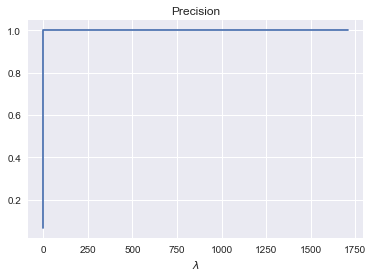

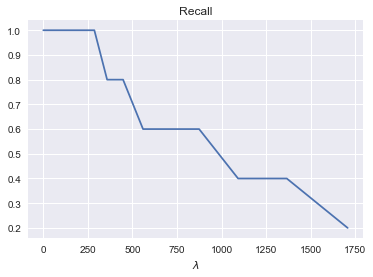

In [7]:
y,x,w_star,k = generateData()
w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec = lasso_loop(x,y,k)
plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k)

In [25]:
num_non_zero_vec
correct_non_zero_vec
lambda_vec

precision = np.array(correct_non_zero_vec)/np.array(num_non_zero_vec)
precision


[0,
 2,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 9,
 11,
 18,
 20,
 17,
 73]

[0,
 2,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

[1445.4007125934627,
 1156.3205700747701,
 925.05645605981613,
 740.0451648478529,
 592.03613187828239,
 473.62890550262591,
 378.90312440210073,
 303.1224995216806,
 242.49799961734448,
 193.9983996938756,
 155.19871975510048,
 124.1589758040804,
 99.327180643264327,
 79.461744514611468,
 63.569395611689174,
 50.855516489351345,
 40.684413191481077,
 32.547530553184863,
 26.038024442547893,
 20.830419554038315,
 16.664335643230654,
 13.331468514584524,
 10.665174811667619,
 8.5321398493340954,
 6.8257118794672769,
 5.4605695035738222,
 4.3684556028590578,
 3.4947644822872466,
 2.7958115858297976,
 2.2366492686638382,
 1.7893194149310707,
 1.4314555319448568,
 1.1451644255558855,
 0.91613154044470846,
 0.73290523235576677,
 0.58632418588461344,
 0.46905934870769078,
 0.37524747896615263,
 0.30019798317292212,
 0.24015838653833771,
 0.19212670923067018,
 0.15370136738453616,
 0.12296109390762894,
 0.09836887512610315,
 0.078695100100882528,
 0.062956080080706023,
 0.050364864064564821,


/Users/djcald/Virtualenvs/sciPyagain/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


array([        nan,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.83333333,  1.        ,  0.83333333,  0.83333333,  0.83333333,
        0.71428571,  0.71428571,  0.71428571,  0.55555556,  0.45454545,
        0.27777778,  0.25      ,  0.29411765,  0.06849315])

In [11]:

lambda_val = 100
w,stop_cond_vec = lasso_CD(x,y,lambda_val)

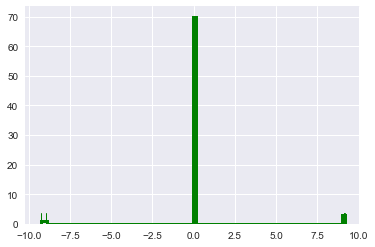

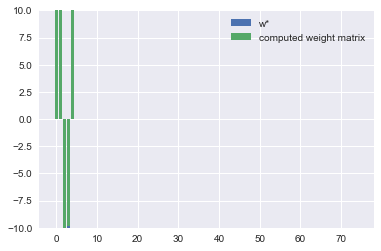

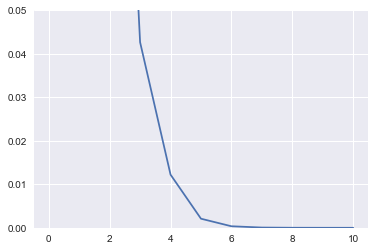

In [12]:
plot_lasso(w,stop_cond_vec,w_star)


In [34]:
np.sum([x==0 for x in w]

69

In [68]:
a = np.row_stack((w,w))

np.shape(a)

sum((x==0 for x in a.T))

(2, 75)

array([69, 69])

In [20]:
ground_truth = np.zeros((np.shape(x)[1],))
ground_truth[0:5] = 1

# total non zero 
num_non_zero = sum((x==0 for x in w))

# correct non zeros 
w_logical = w!=0

ground_truth 
correct_non_zero = sum(w_logical==ground_truth)
w_logical
print(w_logical)

array([ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [94]:
np.logical_and(ground_truth,w_logical)

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [10]:
w_logical = w!=0
w_logical

NameError: name 'w' is not defined